In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Evaluation of model TA bias - expanded

**Notebook overview:** We understand that our carbon model, SalishSeaCast-SKØG, has a slight bias ($\sim$+25 umol/L) in the total alkalinity field. This small bias results in a non-negligible bias in the environmentally-relevant $\Omega_A$ metric that we often consider ($\sim$+0.2). 

In [4]:
#imports
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seawater
import netCDF4 as nc
from scipy import stats

In [5]:
#arrays for storing metrics - first dimension is year, second is region (1-4 is JDF/NSOG/CSOG/HARO, 5 is overall)

reg_cols = ['k', 'orange','green', 'fuchsia',  'blue']

TA_WSS = np.zeros([5,5])
TA_RMSE = np.zeros([5,5])
TA_bias = np.zeros([5,5])
TA_modstd = np.zeros([5,5])
TA_obsstd = np.zeros([5,5])

TA_WSS_over1800 = np.zeros([5,5])
TA_RMSE_over1800 = np.zeros([5,5])
TA_bias_over1800 = np.zeros([5,5])
TA_modstd_over1800 = np.zeros([5,5])
TA_obsstd_over1800 = np.zeros([5,5])

DIC_WSS = np.zeros([5,5])
DIC_RMSE = np.zeros([5,5])
DIC_bias = np.zeros([5,5])
DIC_modstd = np.zeros([5,5])
DIC_obsstd = np.zeros([5,5])

DIC_WSS_over1800 = np.zeros([5,5])
DIC_RMSE_over1800 = np.zeros([5,5])
DIC_bias_over1800 = np.zeros([5,5])
DIC_modstd_over1800 = np.zeros([5,5])
DIC_obsstd_over1800 = np.zeros([5,5])

###### Load observations. 

In [20]:
infil = np.loadtxt('./Datasets/grl2016_nu.txt')
P = infil[:,8]
T = infil[:,9]
S = infil[:,10]
dic = infil[:,13]
alk = infil[:,15]
dic_qf = infil[:,14]
alk_qf = infil[:,16]
dens = seawater.dens(S,T,P)

mask = (((dic_qf==2) | (dic_qf==6)) & \
        ((alk_qf==2) | (alk_qf==6)) & \
        (dic > 0) & (alk >0))
print(np.shape(dic[mask]))

#set non-good values to nan
dic[~mask] = np.nan


# CONVERT FROM UMOL TO MMOL/M3
ta_conv=alk*dens/1000
dic_conv=dic*dens/1000
sal_conv = S * 35.16504/35

#dens check
dens2 = seawater.dens(0.0,0,0); #print(dens)

(425,)


In [21]:
print(np.shape(dic))
print(np.shape(dic[mask]))
print(np.shape(dic[~mask]))
print(np.shape(dic[~np.isnan(dic)]))
print(np.shape(dic[np.isnan(dic)]))
print(np.shape(dic[dic == 0]))

(860,)
(425,)
(435,)
(425,)
(435,)
(0,)


##### Get coordinates of comparable obs and sort into subregions - just once. also get lats, lons of observations

In [22]:
w = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
#print(w['gdept_1d'])
nav_lon = w['nav_lon']
nav_lat = w['nav_lat']

scrdir = './MODEL_EVAL_scripts/'

yr = 2013
TA = nc.Dataset(scrdir+'/TA_hindcast201905_GRL_comp_' + str(yr) + '.nc')
sal = nc.Dataset(scrdir+'/sal_hindcast201905_GRL_comp_' + str(yr) + '.nc')

is_ref = TA['model_output']['mod_x'][:]
js_ref = TA['model_output']['mod_y'][:]
ds_ref = TA['model_output']['depth_index'][:]

loc_tag = np.zeros_like(is_ref)
loc_tag[:] = 4
obs_lon = np.zeros_like(loc_tag)
obs_lat = np.zeros_like(loc_tag)

for w in range(0,len(loc_tag)):
    x = is_ref[w]
    y = js_ref[w]
    
    obs_lon[w] = nav_lon[y,x]
    obs_lat[w] = nav_lat[y,x]
    #jdf is 1
    if  (x <200) & (y>220) & (y<500) :
        loc_tag[w] = 1
        #n strait
    if  (y >= 550):
        loc_tag[w] = 2
        #central strait
    if (x> 150) & (y>380) & (y<550):
        loc_tag[w] = 3
        #4 is haro/puget
    if ((x>150) & (y>320) & (y<370)):
        loc_tag[w] =4

In [23]:
w = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')

loc_tag_surf = np.zeros([898,398])

for w in range(0,len(loc_tag)):
    x = is_ref[w]
    y = js_ref[w]
    
    obs_lon[w] = nav_lon[y,x]
    obs_lat[w] = nav_lat[y,x]
    #jdf is 1
    if  (x <200) & (y>220) & (y<500) :
        loc_tag[w] = 1
        #n strait
    if  (y >= 550):
        loc_tag[w] = 2
        #central strait
    if (x> 150) & (y>380) & (y<550):
        loc_tag[w] = 3
        #4 is haro/puget
    if ((x>150) & (y>320) & (y<370)):
        loc_tag[w] =4

##### extract model DIC and TA for years 2013-2017 

In [25]:
TA_mod_ar = np.zeros([5,420])
DIC_mod_ar = np.zeros([5,420])
sal_mod_ar = np.zeros([5,420])

for yr in range(2013,2018): #2018):
    index = yr - 2013

    scrdir = './MODEL_EVAL_scripts/'
    TA = nc.Dataset(scrdir+'/TA_hindcast201905_GRL_comp_' + str(yr) + '.nc')
    DIC = nc.Dataset(scrdir+'/DIC_hindcast201905_GRL_comp_' + str(yr) + '.nc')
    sal = nc.Dataset(scrdir+'/sal_hindcast201905_GRL_comp_' + str(yr) + '.nc')

    TA_mod = TA['model_output']['mod_point'][:]
    DIC_mod = DIC['model_output']['mod_point'][:]
    sal_mod = sal['model_output']['mod_point'][:]
    
    TA_mod[TA_mod==0]=np.nan
    DIC_mod[TA_mod==0]=np.nan
    sal_mod[sal_mod==0]=np.nan
    
    #mask - both carbonate vars have to exist in both model and observations
    mask = (~np.isnan(TA_mod))&(~np.isnan(ta_conv)) & (~np.isnan(DIC_mod))&(~np.isnan(dic_conv))
    
    # apply mask and store in relative indices
    TA_mod_compbl = TA_mod[mask]
    DIC_mod_compbl = DIC_mod[mask]
    sal_mod_compbl = sal_mod[mask]
    
    TA_mod_ar[index,:] = TA_mod_compbl
    sal_mod_ar[index,:] = sal_mod_compbl
    DIC_mod_ar[index,:] = DIC_mod_compbl
    
    # also extract compbl obs
    TA_compbl = ta_conv[mask]
    DIC_compbl = dic_conv[mask]
    sal_compbl = sal_conv[mask]
    
    #also extract SPACE INFORMATION (geographic information)
    is_ref_compbl = is_ref[mask]; js_ref_compbl = js_ref[mask];
    ds_ref_compbl = ds_ref[mask]
    loc_tag_compbl = loc_tag[mask]
    obs_lon_compbl = obs_lon[mask]
    obs_lat_compbl = obs_lat[mask]

#### calculate the metrics WSS, RMSE, and BIAS for DIC AND TA for all 5 years

In [26]:
sal_bias = np.zeros([5,5])

for yr in range(0,5):
    
    TA_mod = TA_mod_ar[yr,:]
    TA_obs =TA_compbl
    
    for i in range(1,5):
        mask = (loc_tag_compbl == i)
        mod = TA_mod[mask]; obs = TA_obs[mask]
        xbar = np.mean(obs)
  
        TA_bias[yr,i-1] = (-np.mean(obs) + np.mean(mod))
        TA_RMSE[yr,i-1] = (np.sqrt(np.sum((mod - obs)**2) /len(obs)))
        TA_WSS[yr,i-1] = (1-(np.sum((mod - obs)**2)  / np.sum((np.abs(mod - xbar) + np.abs(obs - xbar))**2)))
        TA_modstd[yr,i-1] = np.std(mod)
        TA_obsstd[yr,i-1] = np.std(obs)
    
    mod = TA_mod; obs = TA_obs; xbar = np.mean(obs)
    
    TA_bias[yr,4] = (-np.mean(obs) + np.mean(mod))
    TA_RMSE[yr,4] = (np.sqrt(np.sum((mod - obs)**2) /len(obs)))
    TA_WSS[yr,4] = (1-(np.sum((mod - obs)**2)  / np.sum((np.abs(mod - xbar) + np.abs(obs - xbar))**2)))
    TA_modstd[yr,4] = np.std(mod)
    TA_obsstd[yr,4] = np.std(obs)

for yr in range(0,5):
    
    DIC_mod = DIC_mod_ar[yr,:]
    DIC_obs =DIC_compbl
    
    for i in range(1,5):
        mask = (loc_tag_compbl == i)
        mod = DIC_mod[mask]; obs = DIC_obs[mask]
        xbar = np.mean(obs)
  
        DIC_bias[yr,i-1] = (-np.mean(obs) + np.mean(mod))
        DIC_RMSE[yr,i-1] = (np.sqrt(np.sum((mod - obs)**2) /len(obs)))
        DIC_WSS[yr,i-1] = (1-(np.sum((mod - obs)**2)  / np.sum((np.abs(mod - xbar) + np.abs(obs - xbar))**2)))
        DIC_modstd[yr,i-1] = np.std(mod)
        DIC_obsstd[yr,i-1] = np.std(obs)
    
    mod = DIC_mod; obs = DIC_obs; xbar = np.mean(obs)

    DIC_bias[yr,4] = (-np.mean(obs) + np.mean(mod))
    DIC_RMSE[yr,4] = (np.sqrt(np.sum((mod - obs)**2) /len(obs)))
    DIC_WSS[yr,4] = (1-(np.sum((mod - obs)**2)  / np.sum((np.abs(mod - xbar) + np.abs(obs - xbar))**2)))
    DIC_modstd[yr,4] = np.std(mod)
    DIC_obsstd[yr,4] = np.std(obs)
    
for yr in range(0,5):
    
    sal_mod = sal_mod_ar[yr,:]
    sal_obs =sal_compbl
    
    for i in range(1,5):
        mask = (loc_tag_compbl == i)
        mod = sal_mod[mask]; obs = sal_obs[mask]
        xbar = np.mean(obs)
  
        sal_bias[yr,i-1] = (-np.mean(obs) + np.mean(mod))
    
    sal_bias[yr,4] = (-np.mean(obs) + np.mean(mod))
    
    

In [27]:
print('TA bias (columns: JdF, Nsog, Csog, Haro, all)')
print(TA_bias)
print('sal bias (columns: JdF, Nsog, Csog, Haro, all)')
print(sal_bias)

TA bias (columns: JdF, Nsog, Csog, Haro, all)
[[ 5.23529985 47.25043959 24.71733366 13.97822951 25.42846721]
 [ 3.94892871 46.23578794 39.1314426   1.77594658 28.77570435]
 [ 1.61363353 47.77519202 30.11484253  9.57968856 26.32342396]
 [ 3.82750363 42.39217714 32.63282281  9.46602868 26.26634359]
 [ 2.98233238 40.4814705  34.97794854  4.84923843 25.84027199]]
sal bias (columns: JdF, Nsog, Csog, Haro, all)
[[-0.01738753  0.59874942  0.313577    0.11509628  0.11509628]
 [-0.11477489  0.54695618  0.57659945 -0.20475399 -0.20475399]
 [-0.10583101  0.55220462  0.36195367 -0.02093013 -0.02093013]
 [-0.09817289  0.44226406  0.42706734 -0.02556144 -0.02556144]
 [-0.15755771  0.41330074  0.46041913 -0.1459601  -0.1459601 ]]


### plot evaluation metrics, overall and by region. 

We see that the TA bias is lowest near the western boundary and highest near the Johnstone Strait boundary. Willmott Skill scores are consistently high for a model of this type but lowest in the Northern Strait. We capture much of the variability (ratio of std. devs) and our bias is much less than our root mean square error. 


In [28]:
## calculate observational ratio
TA_stdrat = np.zeros([5,5])
DIC_stdrat = np.zeros([5,5])

for i in range(0,5):
    
    TA_stdrat[i,:] = TA_modstd[i,:]/TA_obsstd[i,:]
    DIC_stdrat[i,:] = DIC_modstd[i,:]/DIC_obsstd[i,:]
    
    #p
    #print(np.divide(TA_modstd[i,:]/TA_obsstd[i,:]))
    #DIC_stdrat[i,:] = np.divide(DIC_modstd[i,:]/DIC_obsstd[i,:])

In [29]:
reglabs = ['JDF','NSOG','CSOG','HARO','full domain']
for i in range(1,5):
    print(f'No. observations in {reglabs[i-1]}: {np.size(loc_tag_compbl[loc_tag_compbl == i])}')

No. observations in JDF: 84
No. observations in NSOG: 114
No. observations in CSOG: 163
No. observations in HARO: 59


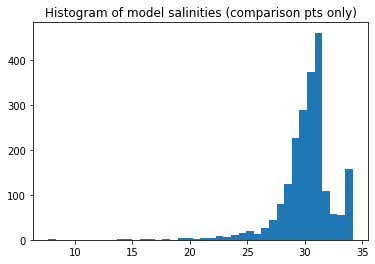

0.6138095238095238
0.35714285714285715
0.14095238095238094


In [30]:
plt.hist(np.ravel(sal_mod_ar), bins = 40)
plt.title('Histogram of model salinities (comparison pts only)')
plt.show()


print(np.size(sal_mod_ar[sal_mod_ar>30])/np.size(sal_mod_ar))
print(np.size(sal_mod_ar[sal_mod_ar>31])/np.size(sal_mod_ar))
print(np.size(sal_mod_ar[sal_mod_ar>32])/np.size(sal_mod_ar))

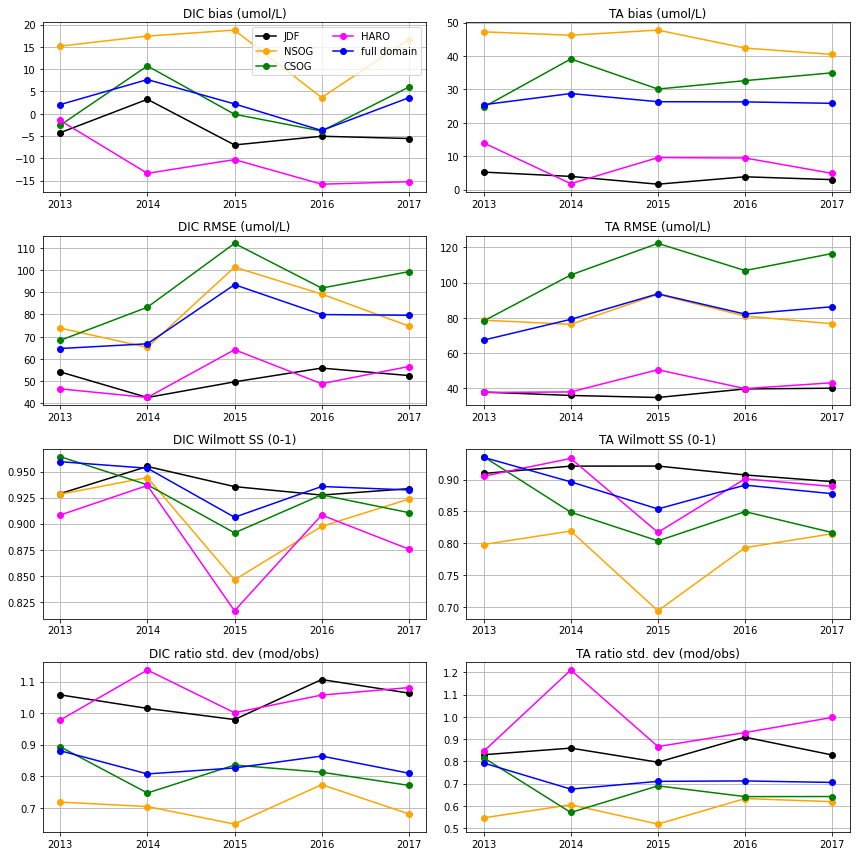

In [31]:
#### extract model DIC and TA for years 2013-2017 

plotabs = [DIC_bias, TA_bias, DIC_RMSE, TA_RMSE, DIC_WSS, TA_WSS, DIC_stdrat, TA_stdrat]
reglabs = ['JDF','NSOG','CSOG','HARO','full domain']
titles = ['DIC bias (umol/L)','TA bias (umol/L)', \
          'DIC RMSE (umol/L)', 'TA RMSE (umol/L)',\
          'DIC Wilmott SS (0-1)', 'TA Wilmott SS (0-1)',
         'DIC ratio std. dev (mod/obs)', 'TA ratio std. dev (mod/obs)']

yrs = np.arange(2013,2018,1)
fact = 0.6
fig, axs = plt.subplots(4,2, figsize=(20*fact, 20*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(0,8):
    tplot = plotabs[i]
    
    for y in range(0,5):
        axs[i].plot(yrs,tplot[:,y],color = reg_cols[y], marker = 'o', label = reglabs[y])
        axs[i].set_xticks(yrs)
        axs[i].grid(); axs[i].set_title(titles[i])
    
    if i == 0:
        axs[i].legend(ncol =2, loc = 'best')
        
plt.tight_layout()

#### Plot TA model vs. obs, as well as TA vs salinity

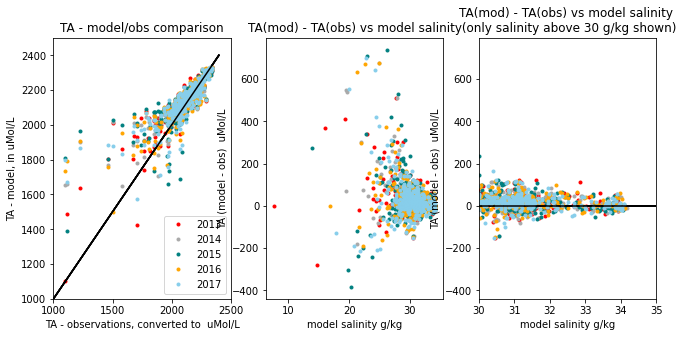

In [25]:
colours = ['red','darkgrey','teal','orange','skyblue']
fact = 0.4
fig, axs = plt.subplots(1,3, figsize=(27*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(0,5):
        axs[0].plot(TA_compbl,TA_mod_ar[i,:],color = colours[i], marker = '.', linestyle = '', label = str(i+2013))
        axs[0].plot([0,2400],[0,2400],'k-')
        axs[0].set_xlim(1000,2500); axs[0].set_ylim(1000,2500); 
        axs[0].set_xlabel('TA - observations, converted to  uMol/L')
        axs[0].set_ylabel('TA - model, in uMol/L')
        axs[0].legend(loc = 'best'); axs[0].set_title('TA - model/obs comparison')
        
        axs[1].plot(sal_mod_ar[i,:],TA_mod_ar[i,:]-TA_compbl,color = colours[i],\
                    marker = '.', linestyle = '', label = str(i+2013))
        axs[1].set_xlabel('model salinity g/kg')
        axs[1].set_ylabel('TA (model - obs)  uMol/L')
        axs[1].set_title('TA(mod) - TA(obs) vs model salinity')
        
        axs[2].plot(sal_mod_ar[i,:],TA_mod_ar[i,:]-TA_compbl,color = colours[i],\
                    marker = '.', linestyle = '', label = str(i+2013))
        axs[2].plot([30,35],[0,0],'k-')
        axs[2].set_xlabel('model salinity g/kg')
        axs[2].set_ylabel('TA (model - obs)  uMol/L')
        axs[2].set_title('TA(mod) - TA(obs) vs model salinity \n (only salinity above 30 g/kg shown)')
        axs[2].set_xlim(30,35);
        
        #axs[1].plot([0,2400],[0,2400],'k-')
        #axs[0].set_xlim(1000,2500); axs[0].set_ylim(1000,2500); 

## binned mean bias as a function of salinity, for whole domain as well as JdF only...

In [26]:
binned_sal = np.arange(10,35,0.5)
binned_mean_bias = np.zeros([5,len(binned_sal)])


for j in range (0,5):
    for i in range(0,len(binned_sal)):
        
        tsal = sal_mod_ar[j,:]; tTA = TA_mod_ar[j,:]
        tsal_sel = (tsal >= binned_sal[i]) & (tsal < binned_sal[i]+0.5)
        binned_mean_bias[j,i] = np.nanmean(tTA[tsal_sel]-TA_compbl[tsal_sel])

binned_mean_bias_jdf = np.zeros([5,len(binned_sal)])

for j in range (0,5):
    for i in range(0,len(binned_sal)):
        
        tsal = sal_mod_ar[j,:]; tTA = TA_mod_ar[j,:]
        tsal_sel = (tsal >= binned_sal[i]) & (tsal < binned_sal[i]+0.5) & (loc_tag_compbl ==1)
        binned_mean_bias_jdf[j,i] = np.nanmean(tTA[tsal_sel]-TA_compbl[tsal_sel])
    

/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice


In [27]:
print()
print('points available for comparison in JdF')
print(np.shape(loc_tag_compbl[loc_tag_compbl == 1]))
print('points in comparison where sal >= 30 g/kg (year 2013)')
print(np.shape(loc_tag_compbl[sal_mod_ar[0,:] >=30]))
print('points in JdF with salinity > 30')
print(np.shape(loc_tag_compbl[(sal_mod_ar[0,:] >=30) & (loc_tag_compbl == 1) ]))
print('points in JdF with salinity > 31')
print(np.shape(loc_tag_compbl[(sal_mod_ar[0,:] >=31) & (loc_tag_compbl == 1) ]))
print('points in JdF with salinity > 32')
print(np.shape(loc_tag_compbl[(sal_mod_ar[0,:] >=32)]))
print('points in JdF with salinity > 33')
print(np.shape(loc_tag_compbl[(sal_mod_ar[0,:] >=33)]))
print('points in JdF with salinity > 34')
print(np.shape(loc_tag_compbl[(sal_mod_ar[0,:] >=34)]))


points available for comparison in JdF
(92,)
points in comparison where sal >= 30 g/kg (year 2013)
(299,)
points in JdF with salinity > 30
(92,)
points in JdF with salinity > 31
(77,)
points in JdF with salinity > 32
(62,)
points in JdF with salinity > 33
(46,)
points in JdF with salinity > 34
(4,)


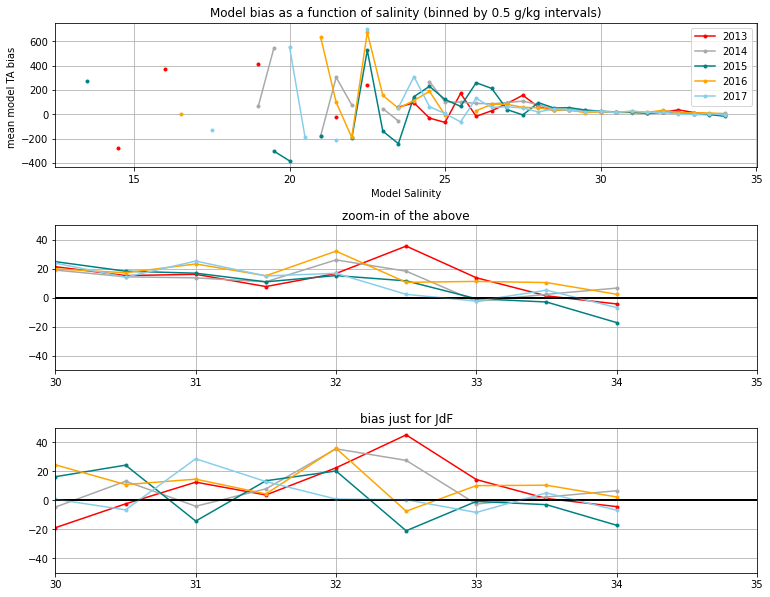

In [28]:
colours = ['red','darkgrey','teal','orange','skyblue']
fact = 0.4
axs = axs.ravel()
fig, axs = plt.subplots(3,1, figsize=(27*fact, 21*fact), facecolor='w', edgecolor='k')


for i in range(0,5):
        axs[0].plot(binned_sal,binned_mean_bias[i,:],color = colours[i], marker = '.', 
                    linestyle = '-', label = str(i+2013))
        axs[0].grid(); axs[0].set_xlabel('Model Salinity'); axs[0].set_ylabel('mean model TA bias ')
        axs[0].set_title('Model bias as a function of salinity (binned by 0.5 g/kg intervals)')
        axs[0].legend()
        
        
        axs[1].plot(binned_sal,binned_mean_bias[i,:],color = colours[i], marker = '.', 
                    linestyle = '-', label = str(i+2013))
        axs[1].set_xlim([30,35]);axs[1].set_ylim([-50,50]);
        axs[1].plot([30,35],[0,0],'k-')
        axs[1].grid()
        axs[1].set_title('zoom-in of the above')
        
        axs[2].plot(binned_sal,binned_mean_bias_jdf[i,:],color = colours[i], marker = '.', 
                    linestyle = '-', label = str(i+2013))
        axs[2].set_xlim([30,35]);axs[2].set_ylim([-50,50]);
        axs[2].plot([30,35],[0,0],'k-')
        axs[2].grid()
        axs[2].set_title('bias just for JdF')
        #axs[0].plot([0,2400],[0,2400],'k-')
        
plt.tight_layout()

In [29]:
np.shape(loc_tag_compbl)

(465,)

## exploring TA-salinity regressions

In [30]:
slopeTA, interceptTA, r_valueTA, p_valueTA, std_errTA = stats.linregress(sal_compbl,TA_compbl)
lineTA = slopeTA*sal_compbl+interceptTA
slopeTA_1, interceptTA_1, r_valueTA_1, p_valueTA_1, std_errTA_1 = \
stats.linregress(sal_compbl[loc_tag_compbl ==1],TA_compbl[loc_tag_compbl ==1])
lineTA_1 = slopeTA_1*sal_compbl[loc_tag_compbl ==1]+interceptTA_1
slopeTA_2, interceptTA_2, r_valueTA_2, p_valueTA_2, std_errTA_2 = \
stats.linregress(sal_compbl[loc_tag_compbl ==2],TA_compbl[loc_tag_compbl ==2])
lineTA_2 = slopeTA_2*sal_compbl[loc_tag_compbl ==2]+interceptTA_2
slopeTA_3, interceptTA_3, r_valueTA_3, p_valueTA_3, std_errTA_3 = \
stats.linregress(sal_compbl[loc_tag_compbl ==3],TA_compbl[loc_tag_compbl ==3])
lineTA_3 = slopeTA_3*sal_compbl[loc_tag_compbl ==3]+interceptTA_3
slopeTA_4, interceptTA_4, r_valueTA_4, p_valueTA_4, std_errTA_4 = \
stats.linregress(sal_compbl[loc_tag_compbl ==4],TA_compbl[loc_tag_compbl ==4])
lineTA_4 = slopeTA_4*sal_compbl[loc_tag_compbl ==4]+interceptTA_4

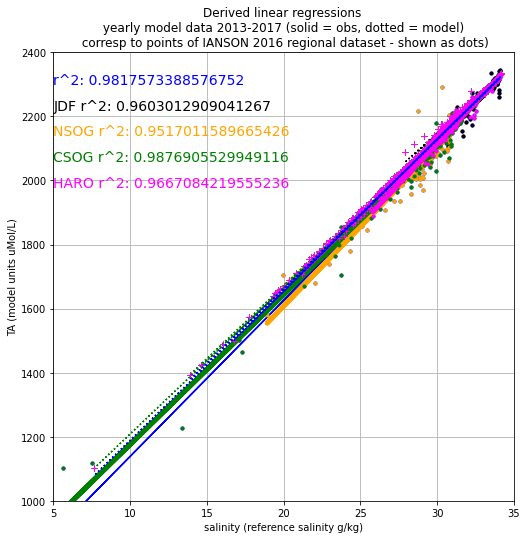

In [31]:
#TA_compbl, TA_mod_ar #sal_compbl, sal_mod_ar, loc_tag_compbl

reglabs = ['JDF','NSOG','CSOG','HARO','full domain']
reg_cols = ['k', 'orange','green', 'fuchsia',  'blue']


fact = 0.55
fig, axs = plt.subplots(1,1, figsize=(15*fact, 15*fact), facecolor='w', edgecolor='k')


axs.plot(sal_compbl,TA_compbl,'b.')
axs.plot(sal_compbl,lineTA,'b-'); 


axs.plot(sal_compbl[loc_tag_compbl == 1],TA_compbl[loc_tag_compbl == 1],'k.')
axs.plot(sal_compbl[loc_tag_compbl == 1], lineTA_1, linestyle = '-', color = 'k', linewidth = 5)

axs.plot(sal_compbl[loc_tag_compbl == 2],TA_compbl[loc_tag_compbl == 2],marker = '.', color = 'orange', linestyle = 'none')
axs.plot(sal_compbl[loc_tag_compbl == 2], lineTA_2, linestyle = '-', color = 'orange', linewidth = 5)

axs.plot(sal_compbl[loc_tag_compbl == 3],TA_compbl[loc_tag_compbl == 3],marker = '.', color = 'green', linestyle = 'none')
axs.plot(sal_compbl[loc_tag_compbl == 3], lineTA_3, linestyle = '-', color = 'green', linewidth = 5)

axs.plot(sal_compbl[loc_tag_compbl == 4],TA_compbl[loc_tag_compbl == 4], marker = '.', color = 'fuchsia', linestyle = 'none')
axs.plot(sal_compbl[loc_tag_compbl == 4], lineTA_4, linestyle = '-', color = 'fuchsia', linewidth = 5)

axs.text(5,2300,f'r^2: {r_valueTA}',fontsize = 14,color = 'blue')
axs.text(5,2220,f'JDF r^2: {r_valueTA_1}',fontsize = 14,color = 'black')
axs.text(5,2140,f'NSOG r^2: {r_valueTA_2}',fontsize = 14,color = 'orange')
axs.text(5,2060,f'CSOG r^2: {r_valueTA_3}',fontsize = 14,color = 'green')
axs.text(5,1980,f'HARO r^2: {r_valueTA_4}',fontsize = 14,color = 'fuchsia')
axs.grid(); axs.set_title('Derived linear regressions \n (IANSON 2016 regional dataset)')
axs.set_xlabel('salinity (converted to reference salinity g/kg)')
axs.set_ylabel('TA (converted to model units uMol/L)')
axs.set_xlim([5,35]); axs.set_ylim([1000,2400])

#### relationships from data
for i in range(0,5):
    sal_mod = sal_mod_ar[i,:]; TA_mod = TA_mod_ar[i,:]
    slopeTA_mod1, interceptTA_mod1, r_valueTA_mod1, p_valueTA_mod1, std_errTA_mod1 = \
    stats.linregress(sal_mod[loc_tag_compbl ==1],TA_mod[loc_tag_compbl ==1])
    #print(slopeTA_mod1)
    lineTA_mod1 = slopeTA_mod1*sal_mod[loc_tag_compbl ==1]+interceptTA_mod1
    axs.plot(sal_mod[loc_tag_compbl == 1], lineTA_mod1, linestyle = ':', color = 'k')
    axs.plot(sal_mod,TA_mod, marker = '+', color = 'black', linestyle = '')
    
for i in range(0,5):
    sal_mod = sal_mod_ar[i,:]; TA_mod = TA_mod_ar[i,:]
    slopeTA_mod2, interceptTA_mod2, r_valueTA_mod2, p_valueTA_mod2, std_errTA_mod2 = \
    stats.linregress(sal_mod[loc_tag_compbl ==2],TA_mod[loc_tag_compbl ==2])
    #print(slopeTA_mod2)
    lineTA_mod2 = slopeTA_mod2*sal_mod[loc_tag_compbl ==2]+interceptTA_mod2
    axs.plot(sal_mod[loc_tag_compbl == 2], lineTA_mod2, linestyle = ':', color = 'orange')
    axs.plot(sal_mod,TA_mod, marker = '+', color = 'orange', linestyle = '')

for i in range(0,5):
    sal_mod = sal_mod_ar[i,:]; TA_mod = TA_mod_ar[i,:]
    slopeTA_mod3, interceptTA_mod3, r_valueTA_mod3, p_valueTA_mod3, std_errTA_mod3 = \
    stats.linregress(sal_mod[loc_tag_compbl ==3],TA_mod[loc_tag_compbl ==3])
    #print(slopeTA_mod3)
    lineTA_mod3 = slopeTA_mod3*sal_mod[loc_tag_compbl ==3]+interceptTA_mod3
    axs.plot(sal_mod[loc_tag_compbl == 3], lineTA_mod3, linestyle = ':', color = 'green')
    axs.plot(sal_mod,TA_mod, marker = '+', color = 'green', linestyle = '')
    
for i in range(0,5):
    sal_mod = sal_mod_ar[i,:]; TA_mod = TA_mod_ar[i,:]
    slopeTA_mod4, interceptTA_mod4, r_valueTA_mod4, p_valueTA_mod4, std_errTA_mod4 = \
    stats.linregress(sal_mod[loc_tag_compbl ==4],TA_mod[loc_tag_compbl ==4])
    #print(slopeTA_mod4)
    lineTA_mod4 = slopeTA_mod4*sal_mod[loc_tag_compbl ==4]+interceptTA_mod4
    axs.plot(sal_mod[loc_tag_compbl == 4], lineTA_mod4, linestyle = ':', color = 'fuchsia')
    axs.plot(sal_mod,TA_mod, marker = '+', color = 'fuchsia', linestyle = '')
    
for i in range(0,5):
    sal_mod = sal_mod_ar[i,:]; TA_mod = TA_mod_ar[i,:]
    slopeTA_mod1, interceptTA_mod1, r_valueTA_mod1, p_valueTA_mod1, std_errTA_mod1 = \
    stats.linregress(sal_mod,TA_mod)
    #print(slopeTA_mod1)
    lineTA_mod1 = slopeTA_mod1*sal_mod+interceptTA_mod1
    axs.plot(sal_mod, lineTA_mod1, linestyle = ':', color = 'b')    
    
    
    
axs.grid(); axs.set_title('Derived linear regressions \n yearly model data 2013-2017 (solid = obs, dotted = model) \n corresp to points of IANSON 2016 regional dataset - shown as dots)')
axs.set_xlabel('salinity (reference salinity g/kg)')
axs.set_ylabel('TA (model units uMol/L)'); axs.set_xlim([5,35]); axs.set_ylim([1000,2400])
axs.grid()
#model stuff

#for i in range(0,5):
#        axs.plot(TA_compbl,TA_mod_ar[i,:],color = colours[i], marker = '.', linestyle = '', label = str(i+2013))


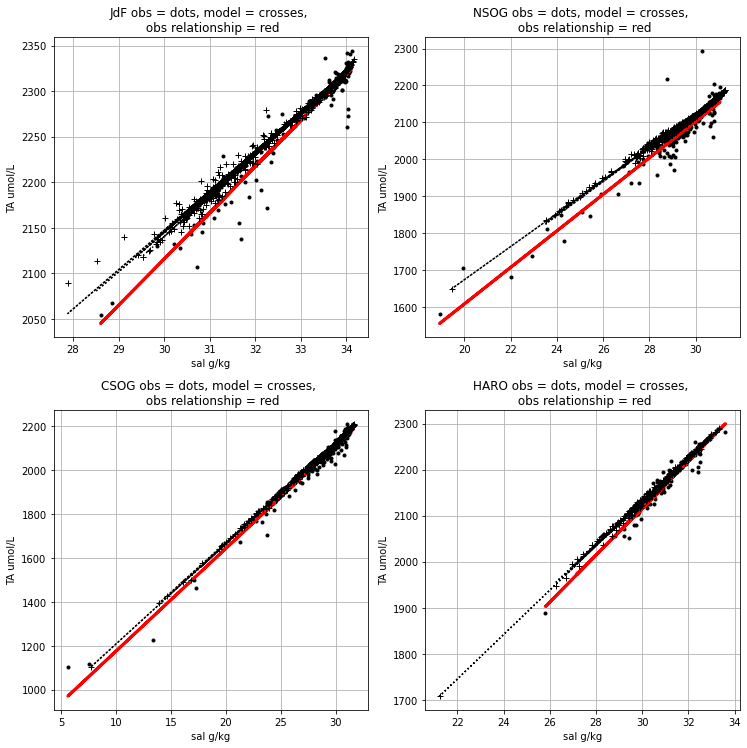

In [32]:
#TA_compbl, TA_mod_ar #sal_compbl, sal_mod_ar, loc_tag_compbl

reglabs = ['JDF','NSOG','CSOG','HARO','full domain']
reg_cols = ['k', 'orange','green', 'fuchsia',  'blue']


fact = 0.7
fig, axsall = plt.subplots(2,2, figsize=(15*fact, 15*fact), facecolor='w', edgecolor='k')
axs2 = axsall.ravel()

axs = axs2[0]

axs.plot(sal_compbl[loc_tag_compbl == 1],TA_compbl[loc_tag_compbl == 1],'k.')
slopeTA_compbl1, interceptTA_compbl1, r_valueTA_compbl1, p_valueTA_compbl1, std_errTA_compbl1 = \
    stats.linregress(sal_compbl[loc_tag_compbl ==1],TA_compbl[loc_tag_compbl ==1])
lineTA_compbl1 = slopeTA_compbl1*sal_compbl[loc_tag_compbl ==1]+interceptTA_compbl1
axs.plot(sal_compbl[loc_tag_compbl == 1], lineTA_compbl1, linestyle = '-', color = 'r', linewidth = 3)

for i in range(0,5):
    sal_mod = sal_mod_ar[i,:]; TA_mod = TA_mod_ar[i,:]
    axs.plot(sal_mod[loc_tag_compbl == 1],TA_mod[loc_tag_compbl == 1],\
             marker = '+', color = 'black', linestyle = '')
    slopeTA_mod1, interceptTA_mod1, r_valueTA_mod1, p_valueTA_mod1, std_errTA_mod1 = \
    stats.linregress(sal_mod[loc_tag_compbl ==1],TA_mod[loc_tag_compbl ==1])
    lineTA_mod1 = slopeTA_mod1*sal_mod[loc_tag_compbl ==1]+interceptTA_mod1
    axs.plot(sal_mod[loc_tag_compbl ==1], lineTA_mod1, linestyle = ':', color = 'black')

axs.grid(); axs.set_xlabel('sal g/kg'); axs.set_ylabel('TA umol/L');
axs.set_title('JdF obs = dots, model = crosses, \n obs relationship = red')

axs = axs2[1]
axs.plot(sal_compbl[loc_tag_compbl ==2],TA_compbl[loc_tag_compbl ==2],'k.')
slopeTA_compbl1, interceptTA_compbl1, r_valueTA_compbl1, p_valueTA_compbl1, std_errTA_compbl1 = \
    stats.linregress(sal_compbl[loc_tag_compbl ==2],TA_compbl[loc_tag_compbl ==2])
lineTA_compbl1 = slopeTA_compbl1*sal_compbl[loc_tag_compbl ==2]+interceptTA_compbl1
axs.plot(sal_compbl[loc_tag_compbl ==2], lineTA_compbl1, linestyle = '-', color = 'r', linewidth = 3)

for i in range(0,5):
    sal_mod = sal_mod_ar[i,:]; TA_mod = TA_mod_ar[i,:]
    axs.plot(sal_mod[loc_tag_compbl ==2],TA_mod[loc_tag_compbl ==2],\
             marker = '+', color = 'black', linestyle = '')
    slopeTA_mod1, interceptTA_mod1, r_valueTA_mod1, p_valueTA_mod1, std_errTA_mod1 = \
    stats.linregress(sal_mod[loc_tag_compbl ==2],TA_mod[loc_tag_compbl ==2])
    lineTA_mod1 = slopeTA_mod1*sal_mod[loc_tag_compbl ==2]+interceptTA_mod1
    axs.plot(sal_mod[loc_tag_compbl ==2], lineTA_mod1, linestyle = ':', color = 'black')
axs.grid(); axs.set_xlabel('sal g/kg'); axs.set_ylabel('TA umol/L');
axs.set_title('NSOG obs = dots, model = crosses, \n obs relationship = red')    

axs = axs2[2]
axs.plot(sal_compbl[loc_tag_compbl ==3],TA_compbl[loc_tag_compbl ==3],'k.')
slopeTA_compbl1, interceptTA_compbl1, r_valueTA_compbl1, p_valueTA_compbl1, std_errTA_compbl1 = \
    stats.linregress(sal_compbl[loc_tag_compbl ==3],TA_compbl[loc_tag_compbl ==3])
lineTA_compbl1 = slopeTA_compbl1*sal_compbl[loc_tag_compbl ==3]+interceptTA_compbl1
axs.plot(sal_compbl[loc_tag_compbl ==3], lineTA_compbl1, linestyle = '-', color = 'r', linewidth = 3)

for i in range(0,5):
    sal_mod = sal_mod_ar[i,:]; TA_mod = TA_mod_ar[i,:]
    axs.plot(sal_mod[loc_tag_compbl ==3],TA_mod[loc_tag_compbl ==3],\
             marker = '+', color = 'black', linestyle = '')
    slopeTA_mod1, interceptTA_mod1, r_valueTA_mod1, p_valueTA_mod1, std_errTA_mod1 = \
    stats.linregress(sal_mod[loc_tag_compbl ==3],TA_mod[loc_tag_compbl ==3])
    lineTA_mod1 = slopeTA_mod1*sal_mod[loc_tag_compbl ==3]+interceptTA_mod1
    axs.plot(sal_mod[loc_tag_compbl ==3], lineTA_mod1, linestyle = ':', color = 'black')
axs.grid(); axs.set_xlabel('sal g/kg'); axs.set_ylabel('TA umol/L');
axs.set_title('CSOG obs = dots, model = crosses, \n obs relationship = red') 
    
axs = axs2[3]
axs.plot(sal_compbl[loc_tag_compbl ==4],TA_compbl[loc_tag_compbl ==4],'k.')
slopeTA_compbl1, interceptTA_compbl1, r_valueTA_compbl1, p_valueTA_compbl1, std_errTA_compbl1 = \
    stats.linregress(sal_compbl[loc_tag_compbl ==4],TA_compbl[loc_tag_compbl ==4])
lineTA_compbl1 = slopeTA_compbl1*sal_compbl[loc_tag_compbl ==4]+interceptTA_compbl1
axs.plot(sal_compbl[loc_tag_compbl ==4], lineTA_compbl1, linestyle = '-', color = 'r', linewidth = 3)

for i in range(0,5):
    sal_mod = sal_mod_ar[i,:]; TA_mod = TA_mod_ar[i,:]
    axs.plot(sal_mod[loc_tag_compbl ==4],TA_mod[loc_tag_compbl ==4],\
             marker = '+', color = 'black', linestyle = '')
    slopeTA_mod1, interceptTA_mod1, r_valueTA_mod1, p_valueTA_mod1, std_errTA_mod1 = \
    stats.linregress(sal_mod[loc_tag_compbl ==4],TA_mod[loc_tag_compbl ==4])
    lineTA_mod1 = slopeTA_mod1*sal_mod[loc_tag_compbl ==4]+interceptTA_mod1
    axs.plot(sal_mod[loc_tag_compbl ==4], lineTA_mod1, linestyle = ':', color = 'black')
axs.grid(); axs.set_xlabel('sal g/kg'); axs.set_ylabel('TA umol/L');
axs.set_title('HARO obs = dots, model = crosses, \n obs relationship = red') 

plt.tight_layout()

### Parker's code to calculate alkalinity

##### note that they are in psu. however alk is in uM > classic model units

    elif vn == 'alkalinity':
        mm = 0*salt
        bb = 0*salt
        if np.nanmax(salt) > 36:
            print('Salt out of range for alkalinity regression')
        # Salinity vs. alkalinity [uM]
        # alkalinity = mm*salt + bb
        ind = (salt < 31.477)
        mm[ind] = 37.0543
        bb[ind] = 1031.0726
        ind = ((salt >= 31.477) & (salt < 33.915))
        mm[ind] = 48.5821
        bb[ind] = 668.2143
        ind = ((salt >= 33.915) & (salt < 35))
        mm[ind] = 246.2214
        bb[ind] = -6034.6841
        alkalinity = mm*salt + bb
        return alkalinity
        
 -- plot our JS data regression
 -- plot theirs
 

In [33]:
def alkfinder(salt):
    mm = 0
    bb = 0
    if np.nanmax(salt) > 36:
        print('Salt out of range for alkalinity regression')
    # Salinity vs. alkalinity [uM]
    # alkalinity = mm*salt + bb
    if (salt < 31.477):
        mm = 37.0543
        bb = 1031.0726
    if ((salt >= 31.477) & (salt < 33.915)):
        mm = 48.5821
        bb = 668.2143
    if ((salt >= 33.915) & (salt < 35)):
        mm = 246.2214
        bb = -6034.6841
    alkalinity = mm*salt + bb
    return alkalinity

salt_PM = np.arange(24,35,0.1)
alk_PM = np.zeros_like(salt_PM)

for i in range(0,len(alk_PM)):
    alk_PM[i] = alkfinder(salt_PM[i])
saltRS_PM = salt_PM * 35.16504/35

#our northern boundary 
alk_JS = 42.62406567350401*saltRS_PM + 835.5069210175448

(1000.0, 2400.0)

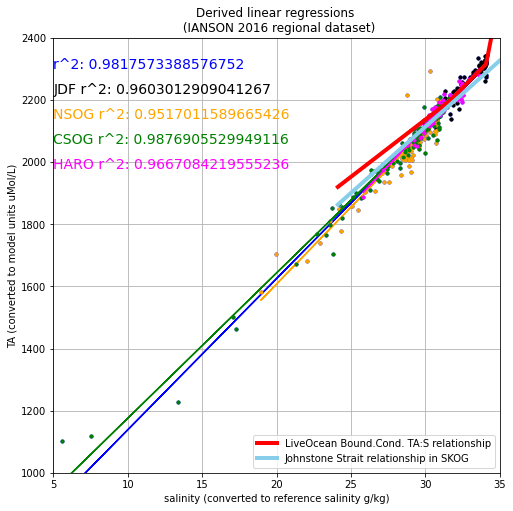

In [34]:
#TA_compbl, TA_mod_ar #sal_compbl, sal_mod_ar, loc_tag_compbl

reglabs = ['JDF','NSOG','CSOG','HARO','full domain']
reg_cols = ['k', 'orange','green', 'fuchsia',  'blue']


fact = 0.8
fig, axs = plt.subplots(1,1, figsize=(10*fact, 10*fact), facecolor='w', edgecolor='k')
#axs = axs.ravel()

axs.plot(sal_compbl,TA_compbl,'b.')
axs.plot(sal_compbl,lineTA,'b-'); 


axs.plot(sal_compbl[loc_tag_compbl == 1],TA_compbl[loc_tag_compbl == 1],'k.')
axs.plot(sal_compbl[loc_tag_compbl == 1], lineTA_1, linestyle = '-', color = 'k')

axs.plot(sal_compbl[loc_tag_compbl == 2],TA_compbl[loc_tag_compbl == 2],marker = '.', color = 'orange', linestyle = 'none')
axs.plot(sal_compbl[loc_tag_compbl == 2], lineTA_2, linestyle = '-', color = 'orange')

axs.plot(sal_compbl[loc_tag_compbl == 3],TA_compbl[loc_tag_compbl == 3],marker = '.', color = 'green', linestyle = 'none')
axs.plot(sal_compbl[loc_tag_compbl == 3], lineTA_3, linestyle = '-', color = 'green')

axs.plot(sal_compbl[loc_tag_compbl == 4],TA_compbl[loc_tag_compbl == 4], marker = '.', color = 'fuchsia', linestyle = 'none')
axs.plot(sal_compbl[loc_tag_compbl == 4], lineTA_4, linestyle = '-', color = 'fuchsia')
axs.plot(saltRS_PM,alk_PM,linestyle = '-', color = 'red', linewidth = 4, label = 'LiveOcean Bound.Cond. TA:S relationship')
axs.plot(saltRS_PM,alk_JS,linestyle = '-', color = 'skyblue', linewidth = 4, label = 'Johnstone Strait relationship in SKOG')

axs.text(5,2300,f'r^2: {r_valueTA}',fontsize = 14,color = 'blue')
axs.text(5,2220,f'JDF r^2: {r_valueTA_1}',fontsize = 14,color = 'black')
axs.text(5,2140,f'NSOG r^2: {r_valueTA_2}',fontsize = 14,color = 'orange')
axs.text(5,2060,f'CSOG r^2: {r_valueTA_3}',fontsize = 14,color = 'green')
axs.text(5,1980,f'HARO r^2: {r_valueTA_4}',fontsize = 14,color = 'fuchsia')
axs.grid(); axs.set_title('Derived linear regressions \n (IANSON 2016 regional dataset)')
axs.legend(loc=4)
axs.set_xlabel('salinity (converted to reference salinity g/kg)')
axs.set_ylabel('TA (converted to model units uMol/L)')
axs.set_xlim([5,35]); axs.set_ylim([1000,2400])



(1800.0, 2400.0)

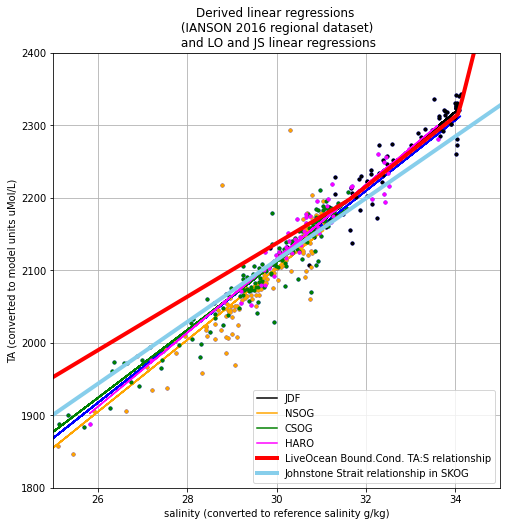

In [35]:
#TA_compbl, TA_mod_ar #sal_compbl, sal_mod_ar, loc_tag_compbl

reglabs = ['JDF','NSOG','CSOG','HARO','full domain']
reg_cols = ['k', 'orange','green', 'fuchsia',  'blue']


fact = 0.8
fig, axs = plt.subplots(1,1, figsize=(10*fact, 10*fact), facecolor='w', edgecolor='k')
#axs = axs.ravel()

axs.plot(sal_compbl,TA_compbl,'b.')
axs.plot(sal_compbl,lineTA,'b-'); 


axs.plot(sal_compbl[loc_tag_compbl == 1],TA_compbl[loc_tag_compbl == 1],'k.')
axs.plot(sal_compbl[loc_tag_compbl == 1], lineTA_1, linestyle = '-', color = 'k', label = 'JDF')

axs.plot(sal_compbl[loc_tag_compbl == 2],TA_compbl[loc_tag_compbl == 2],marker = '.', color = 'orange', linestyle = 'none')
axs.plot(sal_compbl[loc_tag_compbl == 2], lineTA_2, linestyle = '-', color = 'orange', label = 'NSOG')

axs.plot(sal_compbl[loc_tag_compbl == 3],TA_compbl[loc_tag_compbl == 3],marker = '.', color = 'green', linestyle = 'none')
axs.plot(sal_compbl[loc_tag_compbl == 3], lineTA_3, linestyle = '-', color = 'green', label = 'CSOG')

axs.plot(sal_compbl[loc_tag_compbl == 4],TA_compbl[loc_tag_compbl == 4], marker = '.', color = 'fuchsia', linestyle = 'none')
axs.plot(sal_compbl[loc_tag_compbl == 4], lineTA_4, linestyle = '-', color = 'fuchsia', label = 'HARO')
axs.plot(saltRS_PM,alk_PM,linestyle = '-', color = 'red', linewidth = 4, label = 'LiveOcean Bound.Cond. TA:S relationship')
axs.plot(saltRS_PM,alk_JS,linestyle = '-', color = 'skyblue', linewidth = 4, label = 'Johnstone Strait relationship in SKOG')

axs.grid(); axs.set_title('Derived linear regressions \n (IANSON 2016 regional dataset) \n and LO and JS linear regressions')
axs.legend(loc=4)
axs.set_xlabel('salinity (converted to reference salinity g/kg)')
axs.set_ylabel('TA (converted to model units uMol/L)')
axs.set_xlim([25,35]); axs.set_ylim([1800,2400])
